In [9]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense, LayerNormalization, BatchNormalization, Activation
import os
import random
from  keras.regularizers import l2
from sklearn.preprocessing import PowerTransformer


In [10]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

train = pd.read_csv('Embeddings/Prot_t5/train_t5_pssm.csv')
train_esm_650 = pd.read_csv('Embeddings/ESM_650/train_esm650.csv')
train_esm_3B = pd.read_csv('Embeddings/ESM_3B/train_esm.csv')


print(train.shape)


# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))


X_train_PSSM = train['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))


X_train_PSSM = np.stack(X_train_PSSM.values)


# Convert to a numpy array if needed
X_train_pt5 = np.stack(X_train_embeddings.values)


# use power transform to normalize the pssm
scaler = PowerTransformer()
X_train_PSSM = scaler.fit_transform(X_train_PSSM)

X_train_esm_650 = train_esm_650['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))


X_train_esm_650 = np.stack(X_train_esm_650.values)


X_train_esm_3B = train_esm_3B['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

X_train_esm_3B = np.stack(X_train_esm_3B.values)

# Extract sequences
X_train = train['sequence'].values


# Extract labels
y_train = train['label'].values


# Extract sequences
X_train = train['sequence'].values


# Extract labels
y_train = train['label'].values


# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]

X_train_num = np.array(X_train_num)

# Pass the sequences through the embedding layer
X_train_num = np.eye(21)[X_train_num]
#flatten the array
X_train_num = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1]*X_train_num.shape[2])


#print shapes
print(X_train_pt5.shape)

print(X_train_esm_650.shape)

print(X_train_esm_3B.shape)

print(X_train_PSSM.shape)

print(X_train_num.shape)

print(y_train.shape)




(8411, 6)
(8411, 1024)
(8411, 1280)
(8411, 2560)
(8411, 20)
(8411, 693)
(8411,)


In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Example with one group (word_embedding)
def apply_pca_to_group(X_group, n_components=10):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_group)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, pca.explained_variance_ratio_

word_embedding_pca, word_embedding_var_ratio = apply_pca_to_group(X_train_num)
print("Word Embedding Explained Variance:", word_embedding_var_ratio)
prot_t5_pca, prot_t5_var_ratio = apply_pca_to_group(X_train_pt5)
print("Prot_t5 Explained Variance:", prot_t5_var_ratio)
esm_650_pca, esm_650_var_ratio = apply_pca_to_group(X_train_esm_650)
print("ESM_650 Explained Variance:", esm_650_var_ratio)
esm_3B_pca, esm_3B_var_ratio = apply_pca_to_group(X_train_esm_3B)
print("ESM_3B Explained Variance:", esm_3B_var_ratio)
pssm_pca, pssm_var_ratio = apply_pca_to_group(X_train_PSSM)
print("PSSM Explained Variance:", pssm_var_ratio)



Word Embedding Explained Variance: [0.01762439 0.01635325 0.00354433 0.00344176 0.00334695 0.00303774
 0.0027774  0.00270296 0.00262217 0.0025964 ]
Prot_t5 Explained Variance: [0.04825255 0.02942512 0.02706921 0.02014168 0.01807627 0.01528529
 0.01364657 0.0124035  0.01174227 0.01119752]
ESM_650 Explained Variance: [0.06721411 0.01911797 0.01506379 0.0121453  0.01150835 0.01074917
 0.00862591 0.0081082  0.00773717 0.00750328]
ESM_3B Explained Variance: [0.05641356 0.0126858  0.00948623 0.00815983 0.00708505 0.00667284
 0.00614067 0.00553382 0.00531766 0.00491339]
PSSM Explained Variance: [0.47052615 0.11999805 0.0768104  0.04755546 0.0406321  0.03425318
 0.0292239  0.02510213 0.02350271 0.02063087]


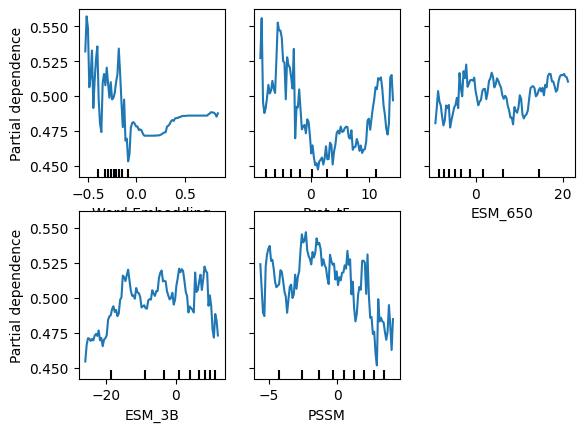

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

# Concatenate all PCA-transformed data
X_train_pca = np.hstack([word_embedding_pca, prot_t5_pca, esm_650_pca, esm_3B_pca, pssm_pca])

# Train a model on the PCA-transformed data
model = RandomForestClassifier()
model.fit(X_train_pca, y_train)  # Assuming y_train is your target variable


# Compute and plot PDP for the selected components
display = PartialDependenceDisplay.from_estimator(model, X_train_pca, features=[0, 1, 2, 3, 4], feature_names=['Word Embedding', 'Prot_t5', 'ESM_650', 'ESM_3B', 'PSSM'])
plt.show()


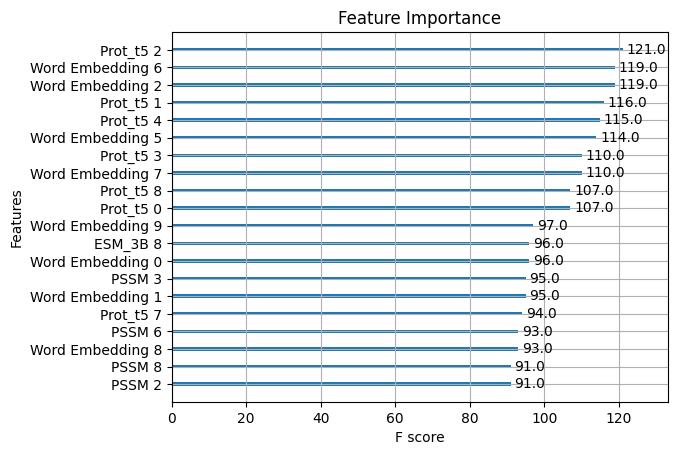

<Figure size 640x480 with 0 Axes>

In [26]:
#feature importance using xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

X_train_pca = np.hstack([word_embedding_pca, prot_t5_pca, esm_650_pca, esm_3B_pca, pssm_pca])

# change feature names to match the PCA components
w_e_names = [f'Word Embedding {i}' for i in range(word_embedding_pca.shape[1])]
prot_t5_names = [f'Prot_t5 {i}' for i in range(prot_t5_pca.shape[1])]
esm_650_names = [f'ESM_650 {i}' for i in range(esm_650_pca.shape[1])]
esm_3B_names = [f'ESM_3B {i}' for i in range(esm_3B_pca.shape[1])]
pssm_names = [f'PSSM {i}' for i in range(pssm_pca.shape[1])]
feature_names = w_e_names + prot_t5_names + esm_650_names + esm_3B_names + pssm_names
X_train_pca = pd.DataFrame(X_train_pca, columns=feature_names)

model = XGBClassifier()
model.fit(X_train_pca, y_train)

plot_importance(model, importance_type='weight', max_num_features=20, title='Feature Importance')
pyplot.show()